
# Task 1


## Load libraries

In [1]:
import os
from PIL import Image, ImageDraw
from pathlib import Path
import numpy as np
import glob

import math
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
from scipy.fftpack import dct

## Feature extraction and image loading functions

In [2]:
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

X_blocks = []
y_blocks = []

def extract_features(img):
    img_dct = dct2(np.asarray(img))
    features = np.concatenate((
        #img_dct[:, :, 0].flatten(), # Each channel
        #img_dct[:, :, 1].flatten(),
        #img_dct[:, :, 2].flatten(),
        img_dct[:, :].flatten(),
        #img.histogram(),
        dct(img.histogram(), norm='ortho'),
        #np.histogram(img_dct[:, :]),
    ))
    #print(features.shape)
    return features

def get_crops(img, only_skin, show=False):
    """
    Generator for each crop of image
    """
    
    w, h = img.size
    cell_w, cell_h = 32, 32;
    stride = 16
    cols = math.floor((w - cell_w) / stride)
    rows = math.floor((h - cell_h) / stride)
    
    draw = ImageDraw.Draw(img)

    for i in range(cols):
        for j in range(rows):
            left = i * stride
            top = j * stride
            right = left + cell_w
            bottom = top + cell_h

            lower = np.array([50, 50, 0], dtype = "uint8")
            upper = np.array([255, 255, 200], dtype = "uint8")
            crop = img.crop((left, top, right, bottom))

            color = np.asarray(crop).mean(axis=0).mean(axis=0)

            condition = ((lower < color) & (color < upper)).all()
            
            if condition or not only_skin:       
                for channel in img.split():
                    yield channel.crop((left, top, right, bottom))
        
def data_iter(dir_name, only_skin):
    # Yelds lists of features
    videos_names = os.listdir(dir_name)
    for video in videos_names:
        video_path = os.path.join(dir_name, video)
        video_frames = Path(video_path).glob("*.jpg")
        print("Processing", video_path)
        for i, frame in enumerate(video_frames):
            img = Image.open(frame)
            for crop in get_crops(img, only_skin=only_skin, show=(i==0)):
                yield extract_features(crop)

## Load training dataset and extract features

In [3]:
proj_dir = "/home/mbernardi/extra/async/ipcv/pdbr/labs/4/"
db_dir = 'Task_1_cropped'
train_dir = 'development'
test_dir = 'evaluation'

# Enter Project Directory
os.chdir(proj_dir)

# Extract dataset images
if os.path.exists(db_dir) :
    print("Dataset is ready !")

# Load Development Videos
real_dir = os.path.join(db_dir,train_dir,'real')
fake_dir = os.path.join(db_dir,train_dir,'fake')

X = list(data_iter(real_dir, only_skin=True))
y = [1] * len(X)

X.extend(data_iter(fake_dir, only_skin=True))
y.extend([0] * (len(X) - len(y)))

Dataset is ready !
Processing Task_1_cropped/development/real/0021
Processing Task_1_cropped/development/real/0023
Processing Task_1_cropped/development/real/0034
Processing Task_1_cropped/development/real/0006
Processing Task_1_cropped/development/real/0015
Processing Task_1_cropped/development/real/0018
Processing Task_1_cropped/development/real/0002
Processing Task_1_cropped/development/real/0019
Processing Task_1_cropped/development/real/0038
Processing Task_1_cropped/development/real/0003
Processing Task_1_cropped/development/real/0012
Processing Task_1_cropped/development/real/0008
Processing Task_1_cropped/development/real/0007
Processing Task_1_cropped/development/real/0031
Processing Task_1_cropped/development/real/0004
Processing Task_1_cropped/development/real/0026
Processing Task_1_cropped/development/real/0028
Processing Task_1_cropped/development/real/0024
Processing Task_1_cropped/development/real/0022
Processing Task_1_cropped/development/real/0025
Processing Task_1_cro

In [4]:
X_blocks = np.array(X)
del X
y_blocks = np.array(y)
del y

rng = np.random.default_rng(1234)
rng.shuffle(X_blocks)
rng = np.random.default_rng(1234)
rng.shuffle(y_blocks)

In [5]:
X_blocks.shape

(232383, 1280)

## Define and train the network

In [6]:
import tensorflow as tf
from tensorflow import keras

import tensorflow.keras as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
# Split the dataset

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
dataset_size = X_blocks.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((X_blocks, y_blocks)).shuffle(SHUFFLE_BUFFER_SIZE)
del X_blocks
del y_blocks

train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)

train_dataset = dataset.take(train_size).batch(BATCH_SIZE)
val_dataset = dataset.skip(train_size).batch(BATCH_SIZE)

In [8]:
#opt = keras.optimizers.Adam(learning_rate=0.001)
opt = 'rmsprop'
metric = tf.keras.metrics.BinaryAccuracy()
loss = tf.keras.losses.MeanSquaredError()

nn = Sequential()

nn.add(tf.keras.layers.BatchNormalization())
nn.add(tf.keras.layers.Dense(500, activation='relu'))
nn.add(tf.keras.layers.Dense(100, activation='relu'))
nn.add(tf.keras.layers.Dense(100, activation='relu'))
nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

nn.compile(loss=loss, optimizer=opt, metrics=[metric])
history = nn.fit(train_dataset, epochs=8, verbose=1, validation_data=val_dataset)

Epoch 1/8
2905/2905 [==============================] - 49s 16ms/step - loss: 0.2064 - binary_accuracy: 0.6619 - val_loss: 0.1424 - val_binary_accuracy: 0.7836
Epoch 2/8
2905/2905 [==============================] - 52s 18ms/step - loss: 0.1325 - binary_accuracy: 0.8022 - val_loss: 0.1317 - val_binary_accuracy: 0.8029
Epoch 3/8
2905/2905 [==============================] - 44s 15ms/step - loss: 0.0981 - binary_accuracy: 0.8605 - val_loss: 0.1236 - val_binary_accuracy: 0.8206
Epoch 4/8
2905/2905 [==============================] - 52s 18ms/step - loss: 0.0772 - binary_accuracy: 0.8941 - val_loss: 0.1255 - val_binary_accuracy: 0.8277
Epoch 5/8
2905/2905 [==============================] - 50s 17ms/step - loss: 0.0627 - binary_accuracy: 0.9172 - val_loss: 0.1282 - val_binary_accuracy: 0.8304
Epoch 6/8
2905/2905 [==============================] - 52s 18ms/step - loss: 0.0541 - binary_accuracy: 0.9298 - val_loss: 0.1260 - val_binary_accuracy: 0.8347
Epoch 7/8
2905/2905 [=========================

## Evaluate in task 1 training dataset

In [9]:
db_dir = 'Task_1'

# Load Test Videos
real_dir = os.path.join(db_dir,train_dir,'real')
fake_dir = os.path.join(db_dir,train_dir,'fake')


real_scores = []
fake_scores = []

# For training Real Images
videos_names = os.listdir(real_dir)
for video in videos_names:
    video_path = os.path.join(real_dir,video)
    video_frames = Path(video_path).glob("*.jpg")
    print("Processing", video_path)
    for frame in video_frames:
        X_test = []
        img = Image.open(frame)
        for crop in get_crops(img, only_skin=False):
            X_test.append(extract_features(crop))
        X_test = np.array(X_test)
        score = np.mean(nn.predict(X_test))
        real_scores.append(score)
        #real_scores.extend(nn.predict(X_test))

# For training Fake Images
videos_names = os.listdir(fake_dir)
for video in videos_names:
    video_path = os.path.join(fake_dir,video)
    video_frames = Path(video_path).glob("*.jpg")
    print("Processing", video_path)
    for frame in video_frames:
        X_test = []
        img = Image.open(frame)
        for crop in get_crops(img, only_skin=False):
            X_test.append(extract_features(crop))
        X_test = np.array(X_test)
        score = np.mean(nn.predict(X_test))
        fake_scores.append(score)
        #fake_scores.extend(nn.predict(X_test))

Processing Task_1/development/real/0021
Processing Task_1/development/real/0023
Processing Task_1/development/real/0034
Processing Task_1/development/real/0006
Processing Task_1/development/real/0015
Processing Task_1/development/real/0018
Processing Task_1/development/real/0002
Processing Task_1/development/real/0019
Processing Task_1/development/real/0038
Processing Task_1/development/real/0003
Processing Task_1/development/real/0012
Processing Task_1/development/real/0008
Processing Task_1/development/real/0007
Processing Task_1/development/real/0031
Processing Task_1/development/real/0004
Processing Task_1/development/real/0026
Processing Task_1/development/real/0028
Processing Task_1/development/real/0024
Processing Task_1/development/real/0022
Processing Task_1/development/real/0025
Processing Task_1/development/real/0033
Processing Task_1/development/real/0010
Processing Task_1/development/real/0036
Processing Task_1/development/real/0037
Processing Task_1/development/real/0027


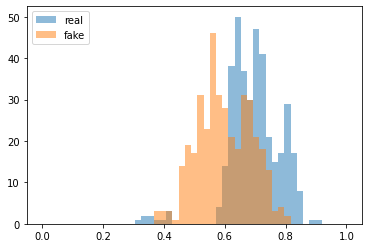

In [10]:
import matplotlib.pyplot as plt

bins = np.linspace(0, 1, 50)

plt.hist(real_scores, bins, alpha = 0.5, label='real')
plt.hist(fake_scores, bins, alpha = 0.5, label='fake')
plt.legend(loc='upper left')

plt.show()

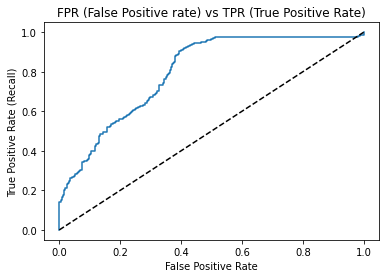

AUC: 0.7953116343490305
EER threshold: 0.656273
EER: 0.3157894736842105
EER: 0.31842105263157894


In [11]:
import sklearn

pred = np.concatenate((
    real_scores,
    fake_scores,
))
ground_truth = np.concatenate((
    np.ones(len(real_scores)),
    np.zeros(len(fake_scores)),
))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(ground_truth, pred)

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_roc(fpr, tpr)

print("AUC:", sklearn.metrics.roc_auc_score(ground_truth, pred))

fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER threshold:", eer_threshold)


eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER:", eer)
eer = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER:", eer)

## Evaluate in task 1 test dataset

In [12]:
db_dir = 'Task_1'

# Load Test Videos
real_dir = os.path.join(db_dir,test_dir,'real')
fake_dir = os.path.join(db_dir,test_dir,'fake')


real_scores = []
fake_scores = []

# For training Real Images
videos_names = os.listdir(real_dir)
for video in videos_names:
    video_path = os.path.join(real_dir,video)
    video_frames = Path(video_path).glob("*.jpg")
    print("Processing", video_path)
    for frame in video_frames:
        X_test = []
        img = Image.open(frame)
        for crop in get_crops(img, only_skin=False):
            X_test.append(extract_features(crop))
        X_test = np.array(X_test)
        score = np.mean(nn.predict(X_test))
        real_scores.append(score)
        #real_scores.extend(nn.predict(X_test))

# For training Fake Images
videos_names = os.listdir(fake_dir)
for video in videos_names:
    video_path = os.path.join(fake_dir,video)
    video_frames = Path(video_path).glob("*.jpg")
    print("Processing", video_path)
    for frame in video_frames:
        X_test = []
        img = Image.open(frame)
        for crop in get_crops(img, only_skin=False):
            X_test.append(extract_features(crop))
        X_test = np.array(X_test)
        score = np.mean(nn.predict(X_test))
        fake_scores.append(score)
        #fake_scores.extend(nn.predict(X_test))

Processing Task_1/evaluation/real/0046
Processing Task_1/evaluation/real/0048
Processing Task_1/evaluation/real/0000
Processing Task_1/evaluation/real/0045
Processing Task_1/evaluation/real/0047
Processing Task_1/evaluation/real/0043
Processing Task_1/evaluation/real/0032
Processing Task_1/evaluation/real/0044
Processing Task_1/evaluation/real/0042
Processing Task_1/evaluation/real/0041
Processing Task_1/evaluation/real/0040
Processing Task_1/evaluation/fake/0041_fake
Processing Task_1/evaluation/fake/0032_fake
Processing Task_1/evaluation/fake/0046_fake
Processing Task_1/evaluation/fake/0047_fake
Processing Task_1/evaluation/fake/0048_fake
Processing Task_1/evaluation/fake/0040_fake
Processing Task_1/evaluation/fake/0000_fake
Processing Task_1/evaluation/fake/0042_fake
Processing Task_1/evaluation/fake/0045_fake
Processing Task_1/evaluation/fake/0044_fake


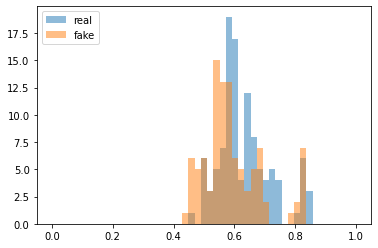

In [13]:
import matplotlib.pyplot as plt

bins = np.linspace(0, 1, 50)

plt.hist(real_scores, bins, alpha = 0.5, label='real')
plt.hist(fake_scores, bins, alpha = 0.5, label='fake')
plt.legend(loc='upper left')

plt.show()

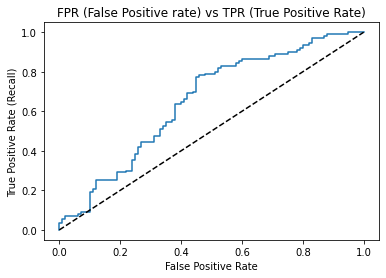

AUC: 0.6503636363636364
EER threshold: 0.5911195
EER: 0.38
EER: 0.36363636363636365


In [14]:
import sklearn

pred = np.concatenate((
    real_scores,
    fake_scores,
))
ground_truth = np.concatenate((
    np.ones(len(real_scores)),
    np.zeros(len(fake_scores)),
))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(ground_truth, pred)

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_roc(fpr, tpr)

print("AUC:", sklearn.metrics.roc_auc_score(ground_truth, pred))

fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER threshold:", eer_threshold)


eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER:", eer)
eer = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER:", eer)

## Evaluate in task 2 dataset

In [15]:
db_dir = 'Task_2_3'

# Load Test Videos
real_dir = os.path.join(db_dir,test_dir,'real')
fake_dir = os.path.join(db_dir,test_dir,'fake')


real_scores = []
fake_scores = []

# For training Real Images
videos_names = os.listdir(real_dir)
for video in videos_names:
    video_path = os.path.join(real_dir,video)
    video_frames = Path(video_path).glob("*.jpg")
    print("Processing", video_path)
    for frame in video_frames:
        X_test = []
        img = Image.open(frame)
        for crop in get_crops(img, only_skin=False):
            X_test.append(extract_features(crop))
        X_test = np.array(X_test)
        score = np.mean(nn.predict(X_test))
        real_scores.append(score)
        #real_scores.extend(nn.predict(X_test))

# For training Fake Images
videos_names = os.listdir(fake_dir)
for video in videos_names:
    video_path = os.path.join(fake_dir,video)
    video_frames = Path(video_path).glob("*.jpg")
    print("Processing", video_path)
    for frame in video_frames:
        X_test = []
        img = Image.open(frame)
        for crop in get_crops(img, only_skin=False):
            X_test.append(extract_features(crop))
        X_test = np.array(X_test)
        score = np.mean(nn.predict(X_test))
        fake_scores.append(score)
        #fake_scores.extend(nn.predict(X_test))

Processing Task_2_3/evaluation/real/id25_0001
Processing Task_2_3/evaluation/real/id34_0008
Processing Task_2_3/evaluation/real/id5_0005
Processing Task_2_3/evaluation/real/id1_0008
Processing Task_2_3/evaluation/real/id36_0003
Processing Task_2_3/evaluation/real/id56_0002
Processing Task_2_3/evaluation/real/id6_0001
Processing Task_2_3/evaluation/real/id42_0004
Processing Task_2_3/evaluation/real/id41_0005
Processing Task_2_3/evaluation/real/id45_0003
Processing Task_2_3/evaluation/real/id12_0003
Processing Task_2_3/evaluation/real/id13_0009
Processing Task_2_3/evaluation/real/id35_0003
Processing Task_2_3/evaluation/real/id0_0003
Processing Task_2_3/evaluation/real/id46_0007
Processing Task_2_3/evaluation/real/id32_0007
Processing Task_2_3/evaluation/real/id44_0005
Processing Task_2_3/evaluation/real/id30_0009
Processing Task_2_3/evaluation/real/id3_0006
Processing Task_2_3/evaluation/real/id10_0001
Processing Task_2_3/evaluation/real/id4_0002
Processing Task_2_3/evaluation/real/id40

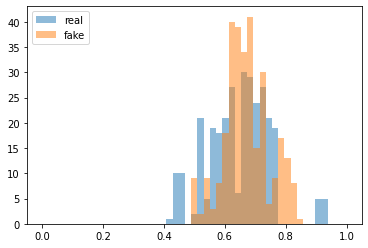

In [16]:
import matplotlib.pyplot as plt

bins = np.linspace(0, 1, 50)

plt.hist(real_scores, bins, alpha = 0.5, label='real')
plt.hist(fake_scores, bins, alpha = 0.5, label='fake')
plt.legend(loc='upper left')

plt.show()

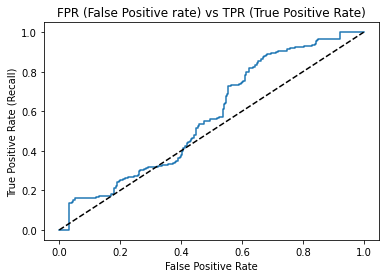

AUC: 0.5738666666666667
EER threshold: 0.6638261
EER: 0.46
EER: 0.4666666666666667


In [17]:
import sklearn

pred = np.concatenate((
    real_scores,
    fake_scores,
))
ground_truth = np.concatenate((
    np.zeros(len(real_scores)),
    np.ones(len(fake_scores)),
))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(ground_truth, pred)

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_roc(fpr, tpr)

print("AUC:", sklearn.metrics.roc_auc_score(ground_truth, pred))

fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER threshold:", eer_threshold)


eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER:", eer)
eer = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER:", eer)